In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate

port_metrics_weekly = df_port_rets_weekly.loc[:,:1].apply(lambda x: pd.Series(performance_metrics(x, market=market_weekly, rf=rf_weekly, freq='W')), axis=0).T #visualization was made for only one portfolio

def performance_metrics(series_in, market=None, rf=None, target=None, freq=None, table=True, plots=True):
    
    # series_in is the pnl series of the asset or the strategy 
    
    periods = series_in.shape[0]# total length of the return series that feed in
    if freq=='Y':
        unit_period = 1
    elif freq=='M':
        unit_period = 12
    elif freq=='W':
        unit_period = 52
    elif freq=='D':
        unit_period = 252
    else:
        print('Please check freq argument!')
        return np.nan
          
    series = series_in.copy()
    idx = series_in.index
    
    if rf is None:
        print('rf is assumed as 0!')        
        series_excess = series.copy()
    elif type(rf)==int or type(rf)==float:
        print('rf converted to unit period in a non-compounding way')
        series_excess = series - rf/unit_period
    else:
        series_excess = series - rf
               
    series_compounded = (series+1).cumprod()
    series_excess_compounded = (series_excess+1).cumprod()
    
    ret_compounded = series_compounded.iloc[-1] - 1
    ret_excess_compounded = series_excess_compounded.iloc[-1] - 1
    cagr = (ret_compounded+1) ** (unit_period/periods) - 1
    
    volatility = series.std() * unit_period**.5
    series_negative = series.copy()
    series_negative[series_negative>0] = 0
    volatility_negative = series_negative.std() * unit_period**.5
    
    sharpe = cagr / volatility
    
    # sortinoe, ref: http://www.sunrisecapital.com/wp-content/uploads/2014/06/Futures_Mag_Sortino_0213.pdf
    sortino = cagr / volatility_negative
    
    # max dd
    
    max_dd_all = (series_compounded / series_compounded.cummax() )
    max_dd = max_dd_all.min()-1
    
    # max_dd duration
    
    max_dddur_all = max_dd_all.copy()
    max_dddur_all[max_dddur_all<1] = 0
    max_dddur_all_cumsum = max_dddur_all.cumsum()
    max_dddur_all = max_dddur_all_cumsum.value_counts()
    max_dddur = max_dddur_all.max() # this is in terms of unit period

    # risk return ratio [similar ratios; calmar, mar, sterling, burke... etc.]
    
    risk_return = cagr / (-max_dd)
    
    # Conditional drawdown  
    condition = .2
    n = int(np.round((max_dddur_all[max_dddur_all>1].shape[0]*condition)))
    conditional_dd = max_dddur_all_cumsum.groupby(max_dddur_all_cumsum).apply(lambda x: max_dd_all.loc[x.index].min()).sort_values().iloc[:n].mean() - 1
    #conditional_dd = 5
    # CDD duration
    
    conditional_dd_dur = max_dddur_all.iloc[:n].mean()
    
    # alpha and beta
    
    def alpha_beta(return_series, market):

        X = market.values.reshape(-1, 1)
        X = np.concatenate([np.ones_like(X), X], axis=1)
        b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(return_series.values)
        return b[0], b[1]
    
    if market is None:
        alpha_raw = ret_compounded
        alpha = np.nan
        beta = np.nan
    else:
        alpha,beta = alpha_beta(series_excess, market)
        alpha_raw = ret_compounded -((market +1).cumprod().iloc[-1]-1)
        
    # treynor ratio
    
    if market is None:
        treynor = np.nan
    else:
        treynor = cagr / beta
    
    # max-min single
    
    max_single = series_in.max()
    min_single = series_in.min()
    
    # skewness -kurt
    
    skewness = series_in.skew()
    kurt = series_in.kurt()
    
    # Var
    
    VaR = series_in.quantile(.05)
    
    #omega ratio
    
    omega = cagr / (-series_negative.mean()) # need to be checked
    
    
    metrics_names = ['Compounded Total Return', 'Compounded Excess Return', 'CAGR',
                     'Annualized Volatility', 'Annualized Negative Volatility', 'Sharpe', 'Sortino',
                     'Treynor', 'Omega', 'Risk-Return', 'alpha Raw', 'alpha',
                     'beta', 'Max Drawdown', 'Conditional Drawdown (Highest 20%)',
                     'Max Drawdown Duration', 'Conditional Drawdown Duration (Longest 20%)',
                     'Maximum Single Period Return', 'Minimum Single Period Return', 'VaR (5%)', 
                     'Skewness', 'Kurtosis']
    
    metrics_values = [ret_compounded, ret_excess_compounded, cagr, volatility,
                      volatility_negative, sharpe, sortino, treynor, omega, 
                      risk_return, alpha_raw, alpha, beta, max_dd, conditional_dd,
                      max_dddur, conditional_dd_dur, max_single, min_single, VaR,
                      skewness, kurt]
    
    dict_table = dict(zip(metrics_names, metrics_values))
    
    
#-----------------------------------------------------------------------------------------------------    
    
    if table:
        print(tabulate(zip(metrics_names, metrics_values), headers=['Metrics', 'Value'], tablefmt="fancy_grid", floatfmt=".4f"))

#-----------------------------------------------------------------------------------------------------
    
    if plots:
        
        #-----------------------------------------------------------------------------------------------------

#        # plotting compounded returns
#        plt.figure()
#        series_compounded.plot(color='red', linewidth=1)
#        #plt.plot(series_compounded)
#        plt.fill_between(series_compounded.index,series_compounded, 1)
#        plt.ylabel("Compounded Returns")
#        plt.xlabel("Date")
#        plt.title("Portfolio in Time");
#        plt.grid(color='black', linestyle='--', linewidth=0.5)
        
        #-----------------------------------------------------------------------------------------------------
        
        # plotting raw returns
        plt.figure()
        plt.plot(series_in.index,series_in,color='blue',linewidth=0.5)
        plt.axhline(y=series_in.mean(), color='red', linewidth=1,linestyle='--')
        plt.ylabel("Return")
        plt.xlabel("Date")
        plt.title('Raw Return')
        plt.grid(color='black', linestyle='--', linewidth=0.5)
        
        #-----------------------------------------------------------------------------------------------------
        
        # plotting underwater figure
        
        plt.figure()
        plt.plot(max_dd_all.index,max_dd_all,color='red',linewidth=0.2)
        plt.fill_between(max_dd_all.index, max_dd_all,1)
        plt.ylabel("Return")
        plt.xlabel("Date")
        plt.title("Underwater graph of highest 5 drawdown");
        plt.grid(color='black', linestyle='--', linewidth=0.5)
        plt.show()
        
        #-----------------------------------------------------------------------------------------------------
        
        # plotting conditional max dd areas
    
        plt.figure()
        list_color=['red','blue','black','green','orange']
        cap_dd_toPlot = 5
        n_dd_toPlot = min(len(max_dddur_all),cap_dd_toPlot)
        
        for i in range(n_dd_toPlot):
            
            start = max_dddur_all_cumsum[(max_dddur_all_cumsum==max_dddur_all.index[i])].index[0]
            stop = max_dddur_all_cumsum[(max_dddur_all_cumsum==max_dddur_all.index[i])].index[-1]
           
           #plt.plot(series_compounded)
            plt.axvspan(start,stop, alpha=0.3, color=list_color[i])
           
        plt.plot(series_compounded)
        plt.show()
        
        
        #-----------------------------------------------------------------------------------------------------
        
        # plotting  returns
        fig, ax = plt.subplots()
        ax= sns.boxplot(saturation=5, fliersize=5,width=0.75,data=series,whis=1)
        ax = sns.swarmplot(data=series, color=".25")
        ax.set(xlabel='Date', ylabel='Return')
        plt.show()
        
        #-----------------------------------------------------------------------------------------------------
        
        # plotting heat map and annual returns
        
        if not freq=='Y':
            
            plt.figure()
            
            years = idx.year.unique()
            
            if freq=='M':
                secondary_period = idx.month.unique().sort_values()
            
            elif freq=='W':
                
                secondary_period_end = series_in.groupby(pd.Grouper(freq='A')).apply(lambda x: x.index.week.unique().shape[0]).max()#range(53)
                secondary_period = range(0,secondary_period_end+1)
                
            elif freq=='D':

                secondary_period_end = max(series_in.groupby(pd.Grouper(freq='A')).apply(lambda x: x.shape[0]).max(),252)#idx.day.unique().sort_values()
                secondary_period = range(0,secondary_period_end)
                
                
            series_grouped = series_in.groupby(series_in.index.year)
        
            ret_perPeriod = pd.concat([series_grouped.get_group(i).reset_index(drop=True) for i in years], axis=1).T
            ret_perPeriod.iloc[0]=ret_perPeriod.iloc[0].shift(ret_perPeriod.iloc[0].isna().sum()) #aligning the nan's as for the first year
            ret_perPeriod.index = years
            ret_perPeriod.columns = secondary_period
        
            plt.ylabel('Date')
            plt.xlabel('Month')
            plt.title('Return')
            #heat_map = 
            sns.heatmap(ret_perPeriod,cbar_kws={'label': 'Colorbar', 'orientation': 'horizontal'}) # ,annot=True,) 
            
            plt.show()
            
            # plot annualized
           
            annualized_perPeriod=(ret_perPeriod.T.replace(np.nan,0)+1).cumprod().iloc[-1,:]-1
            
            fig, ax = plt.subplots()
            y_pos = np.arange(len(annualized_perPeriod))
            
            ax.barh(y_pos,annualized_perPeriod*100, align='center',alpha=0.6)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(years)
            ax.invert_yaxis()  # labels read top-to-bottom
            ax.set_xlabel('Return  % ')
            ax.set_title('Annual Return')
            
            plt.show()        
              
        elif freq == 'Y':
            
            years = idx.year
            
            fig, ax = plt.subplots()
            y_pos = np.arange(len(series))
            
            ax.barh(y_pos,series*100, align='center',alpha=0.6)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(years)
            ax.invert_yaxis()  # labels read top-to-bottom
            ax.set_xlabel('Return  % ')
            ax.set_title('Annual Return')
            
            plt.show()
    

    return dict_table


/tmp/ipykernel_2027/3834668604.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


ModuleNotFoundError: No module named 'tabulate'

In [ ]:
pip install 

In [40]:
data_path = 'data/'
data_daily = pd.read_excel(data_path+'sp500_daily.xlsx')

data_daily.index = pd.to_datetime(data_daily.Date)
port_original_daily = data_daily['Price Close'].pct_change().iloc[1:]
port_original_daily.name = 'SP500'

high_daily = port_original_daily.shape[0]
len_port_daily = 252 * 10
n_port = 1000

market_daily = port_original_daily.iloc[-len_port_daily:]


In [43]:
# constructing portfolios

idx_daily = np.random.randint(0,high_daily,(len_port_daily,n_port))   

df_port_rets_daily = pd.DataFrame(port_original_daily.values[idx_daily], columns = list(range(n_port)), index = list(range(len_port_daily))) 
df_port_rets_daily.index = market_daily.index

corr_port_daily = df_port_rets_daily.corr().values[np.triu_indices(df_port_rets_daily.shape[1], k=1)]
plt.figure(figsize=(10,10))
print(pd.Series(corr_port_daily).describe())
plt.hist(corr_port_daily, bins=1000);

1000

# Monthly test

count    499500.000000
mean          0.000217
std           0.093328
min          -0.412039
25%          -0.063113
50%           0.000327
75%           0.063372
max           0.398079
dtype: float64


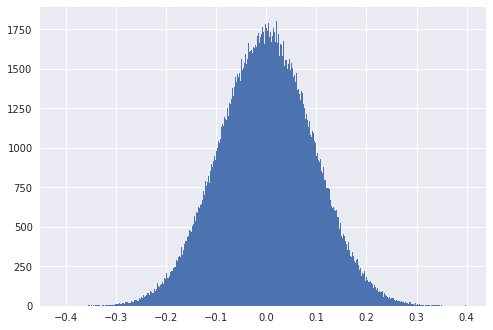

╒═════════════════════════════════════════════╤═════════╕
│ Metrics                                     │   Value │
╞═════════════════════════════════════════════╪═════════╡
│ Compounded Total Return                     │  0.6747 │
├─────────────────────────────────────────────┼─────────┤
│ Compounded Excess Return                    │ -1.0000 │
├─────────────────────────────────────────────┼─────────┤
│ CAGR                                        │  0.0543 │
├─────────────────────────────────────────────┼─────────┤
│ Annualized Volatility                       │  0.1887 │
├─────────────────────────────────────────────┼─────────┤
│ Annualized Negative Volatility              │  0.1009 │
├─────────────────────────────────────────────┼─────────┤
│ Sharpe                                      │  0.2878 │
├─────────────────────────────────────────────┼─────────┤
│ Sortino                                     │  0.5383 │
├─────────────────────────────────────────────┼─────────┤
│ Treynor     

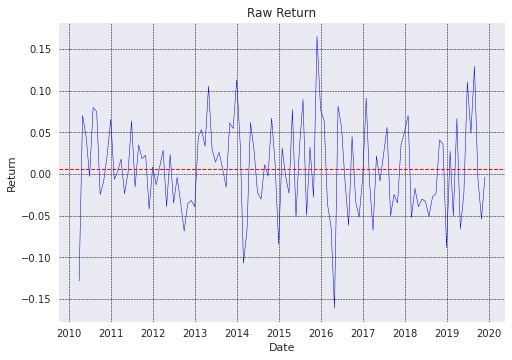

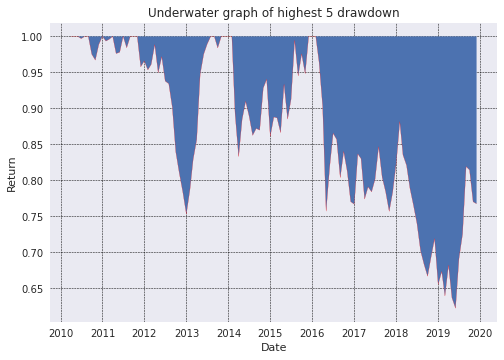

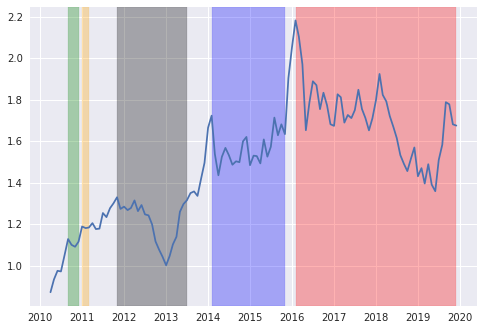

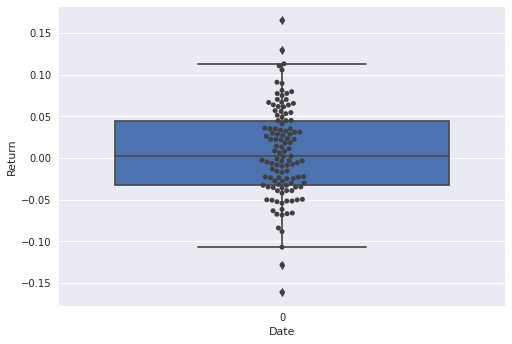

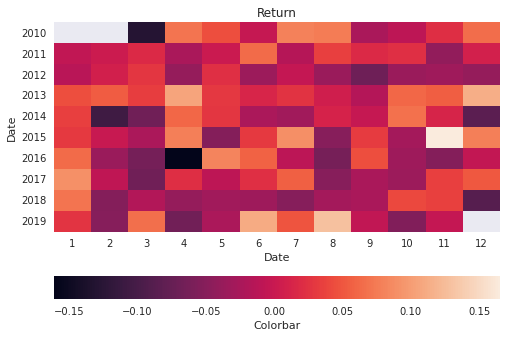

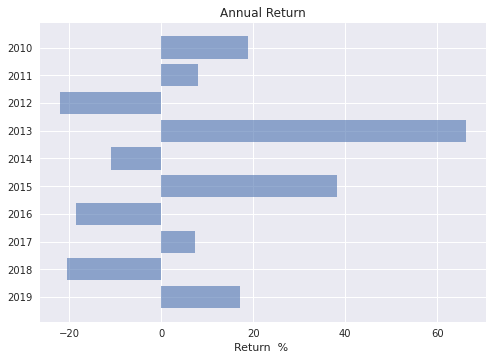

╒═════════════════════════════════════════════╤═════════╕
│ Metrics                                     │   Value │
╞═════════════════════════════════════════════╪═════════╡
│ Compounded Total Return                     │  1.6443 │
├─────────────────────────────────────────────┼─────────┤
│ Compounded Excess Return                    │ -1.0000 │
├─────────────────────────────────────────────┼─────────┤
│ CAGR                                        │  0.1049 │
├─────────────────────────────────────────────┼─────────┤
│ Annualized Volatility                       │  0.1795 │
├─────────────────────────────────────────────┼─────────┤
│ Annualized Negative Volatility              │  0.0956 │
├─────────────────────────────────────────────┼─────────┤
│ Sharpe                                      │  0.5844 │
├─────────────────────────────────────────────┼─────────┤
│ Sortino                                     │  1.0972 │
├─────────────────────────────────────────────┼─────────┤
│ Treynor     

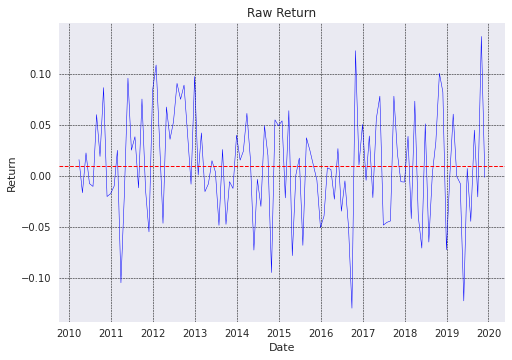

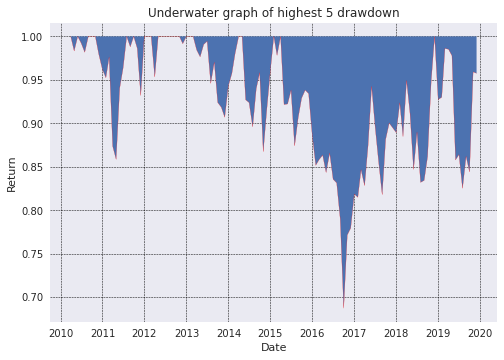

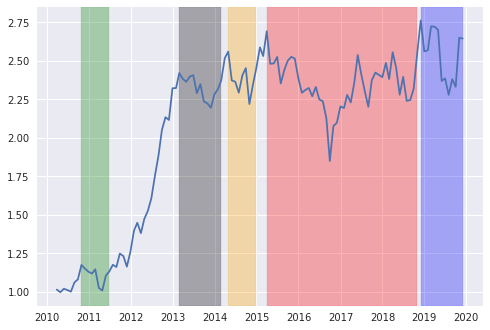

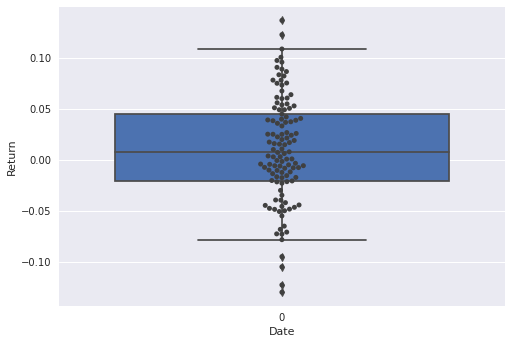

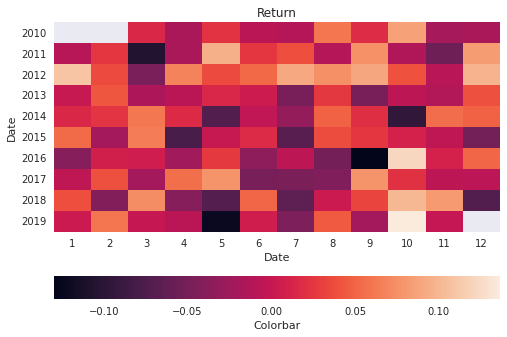

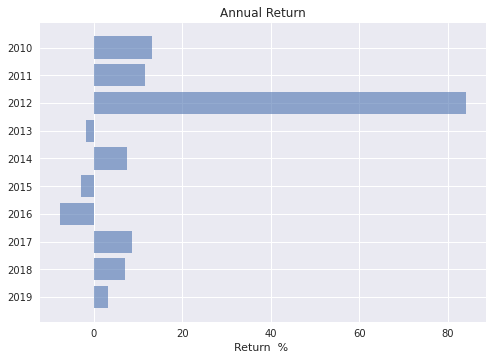

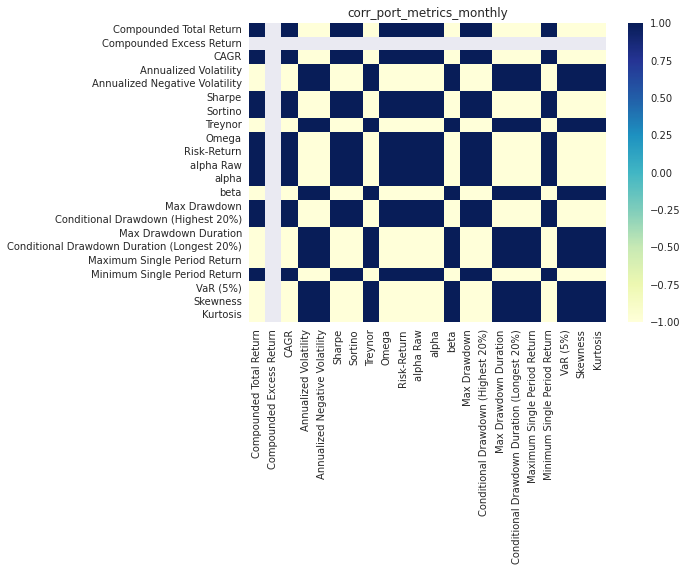

In [6]:
# monthly test
market_monthly = (market_daily+1).groupby(pd.Grouper(freq='M')).apply(np.prod) - 1

#data_rf_monthly = pd.read_excel('/kaggle/input/data-port/M_TB3MS.xls)
#data_rf_monthly = data_rf_monthly.iloc[:,1]

#rf_monthly = data_rf_monthly.iloc[-len_port_monthly:] / 12
#rf_monthly.index = market_monthly.index

rf_monthly=True

# constructing portfolios


df_port_rets_monthly = (df_port_rets_daily+1).groupby(pd.Grouper(freq='M')).apply(np.prod) - 1

corr_port_monthly = df_port_rets_monthly.corr().values[np.triu_indices(df_port_rets_monthly.shape[1], k=1)]
# plt.subplot(2,2,2)
print(pd.Series(corr_port_monthly).describe())
plt.hist(corr_port_monthly, bins=1000);
plt.show()

# calculating metrics
port_metrics_monthly = df_port_rets_monthly.loc[:,:1].apply(lambda x: pd.Series(performance_metrics(x, market=market_monthly, rf=rf_monthly, freq='M')), axis=0).T  #visualization was made for only one portfolio
corr_port_metrics_monthly = port_metrics_monthly.corr()
sns.heatmap(corr_port_metrics_monthly,cmap="YlGnBu").set_title("corr_port_metrics_monthly");

# Weekly test


count    499500.000000
mean         -0.000068
std           0.044863
min          -0.221128
25%          -0.030447
50%          -0.000073
75%           0.030142
max           0.207350
dtype: float64
╒═════════════════════════════════════════════╤══════════╕
│ Metrics                                     │    Value │
╞═════════════════════════════════════════════╪══════════╡
│ Compounded Total Return                     │   0.6747 │
├─────────────────────────────────────────────┼──────────┤
│ Compounded Excess Return                    │  -1.0000 │
├─────────────────────────────────────────────┼──────────┤
│ CAGR                                        │   0.0546 │
├─────────────────────────────────────────────┼──────────┤
│ Annualized Volatility                       │   0.1783 │
├─────────────────────────────────────────────┼──────────┤
│ Annualized Negative Volatility              │   0.1125 │
├─────────────────────────────────────────────┼──────────┤
│ Sharpe                          

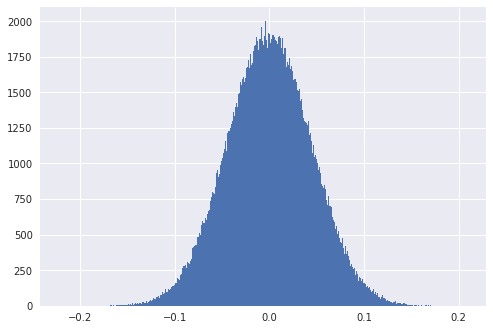

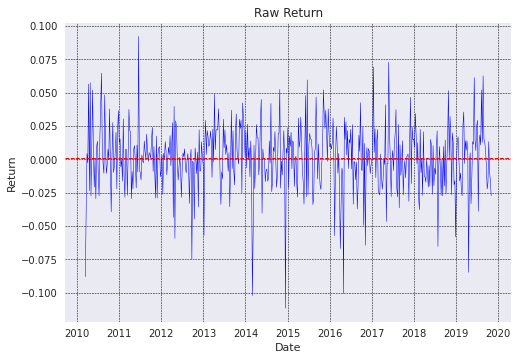

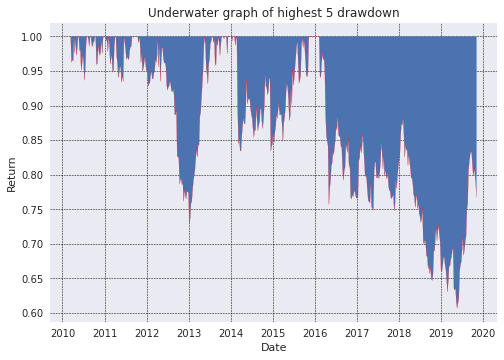

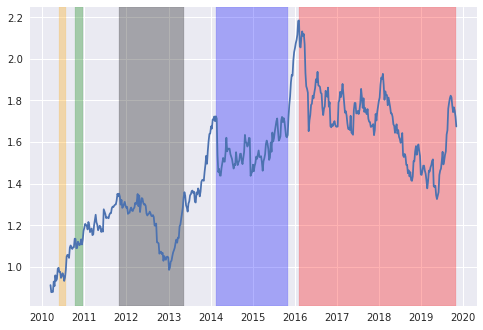

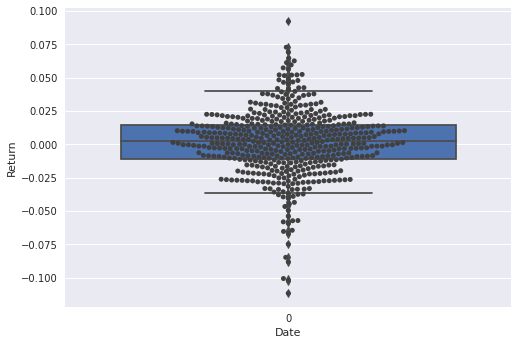

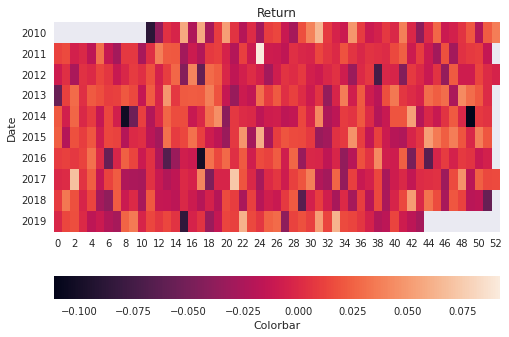

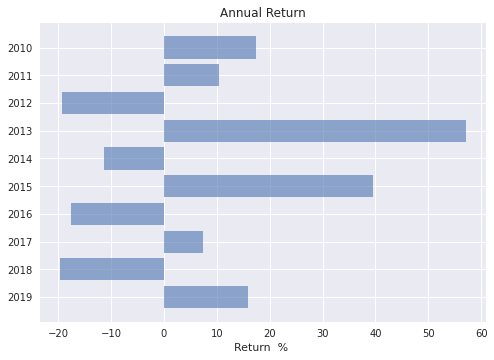

╒═════════════════════════════════════════════╤══════════╕
│ Metrics                                     │    Value │
╞═════════════════════════════════════════════╪══════════╡
│ Compounded Total Return                     │   1.6443 │
├─────────────────────────────────────────────┼──────────┤
│ Compounded Excess Return                    │  -1.0000 │
├─────────────────────────────────────────────┼──────────┤
│ CAGR                                        │   0.1055 │
├─────────────────────────────────────────────┼──────────┤
│ Annualized Volatility                       │   0.1736 │
├─────────────────────────────────────────────┼──────────┤
│ Annualized Negative Volatility              │   0.1014 │
├─────────────────────────────────────────────┼──────────┤
│ Sharpe                                      │   0.6080 │
├─────────────────────────────────────────────┼──────────┤
│ Sortino                                     │   1.0407 │
├─────────────────────────────────────────────┼─────────

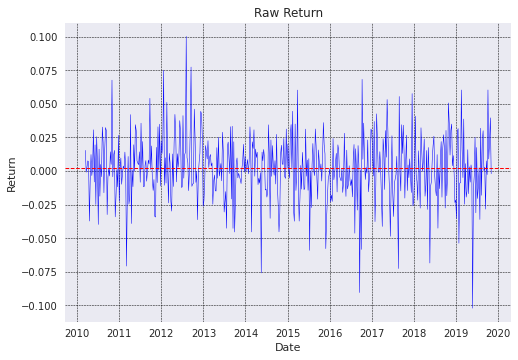

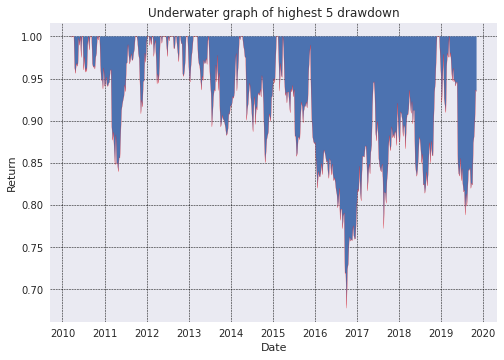

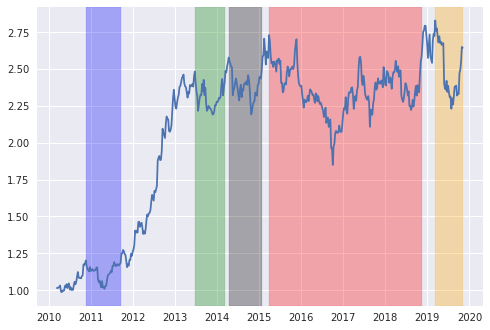

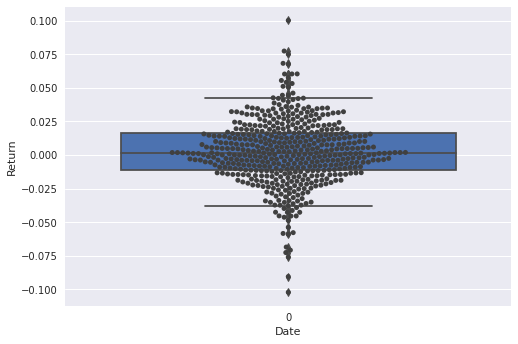

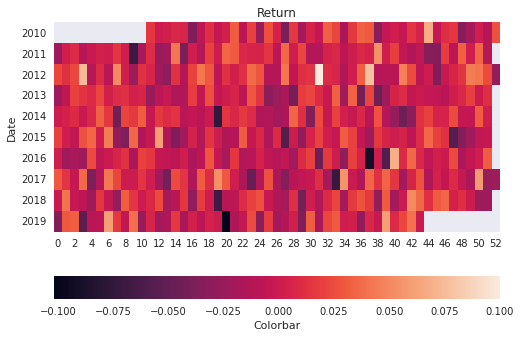

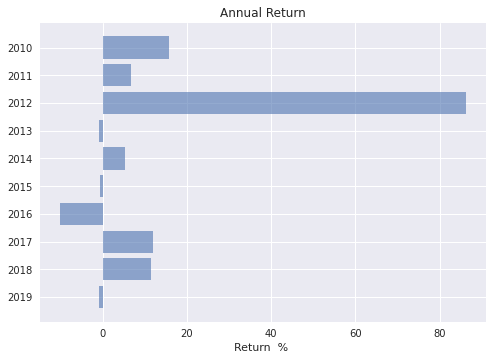

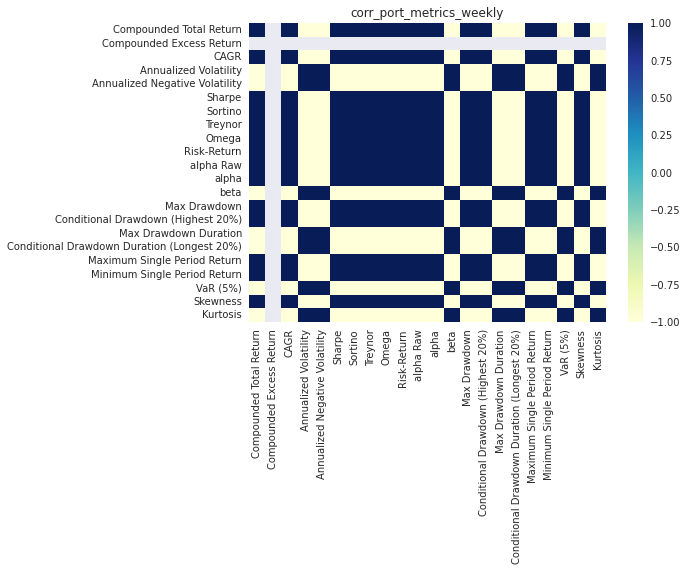

In [7]:
market_weekly = (market_daily+1).groupby(pd.Grouper(freq='W')).apply(np.prod) - 1

#data_rf_weekly = pd.read_excel('/kaggle/input/data-port/M_TB3MS.xls)
#data_rf_weekly = data_rf_weekly.iloc[:,1]

#rf_weekly = data_rf_weekly.iloc[-len_port_weekly:] / 12
#rf_weekly.index = market_weekly.index

rf_weekly=True

# constructing portfolios


df_port_rets_weekly = (df_port_rets_daily+1).groupby(pd.Grouper(freq='W')).apply(np.prod) - 1

corr_port_weekly = df_port_rets_weekly.corr().values[np.triu_indices(df_port_rets_weekly.shape[1], k=1)]

print(pd.Series(corr_port_weekly).describe())
plt.hist(corr_port_weekly, bins=1000)

# calculating metrics

port_metrics_weekly = df_port_rets_weekly.loc[:,:1].apply(lambda x: pd.Series(performance_metrics(x, market=market_weekly, rf=rf_weekly, freq='W')), axis=0).T #visualization was made for only one portfolio

corr_port_metrics_weekly = port_metrics_weekly.corr()
sns.heatmap(corr_port_metrics_weekly,cmap="YlGnBu").set_title("corr_port_metrics_weekly");

#------------------------------------------------------------------------------

# Annual test

count    499500.000000
mean          0.001640
std           0.333879
min          -0.979331
25%          -0.242648
50%          -0.000899
75%           0.243618
max           0.974633
dtype: float64
╒═════════════════════════════════════════════╤═════════╕
│ Metrics                                     │   Value │
╞═════════════════════════════════════════════╪═════════╡
│ Compounded Total Return                     │  0.6747 │
├─────────────────────────────────────────────┼─────────┤
│ Compounded Excess Return                    │ -1.0000 │
├─────────────────────────────────────────────┼─────────┤
│ CAGR                                        │  0.0529 │
├─────────────────────────────────────────────┼─────────┤
│ Annualized Volatility                       │  0.2841 │
├─────────────────────────────────────────────┼─────────┤
│ Annualized Negative Volatility              │  0.0969 │
├─────────────────────────────────────────────┼─────────┤
│ Sharpe                                      │

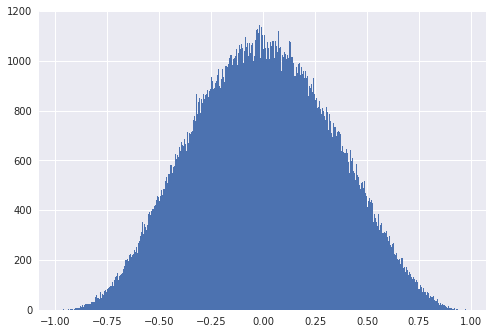

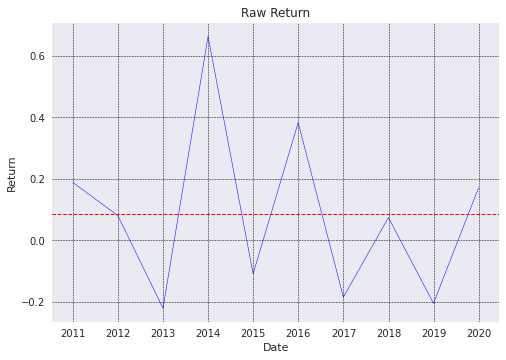

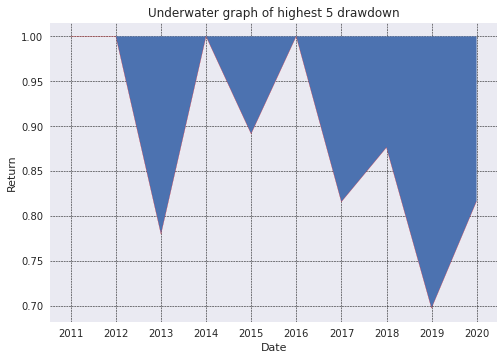

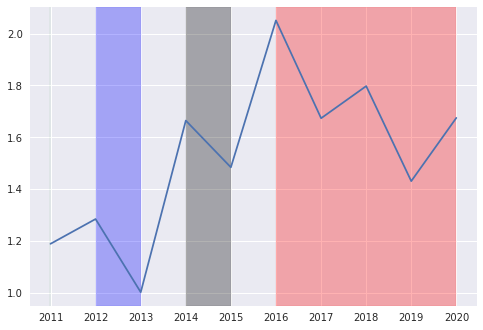

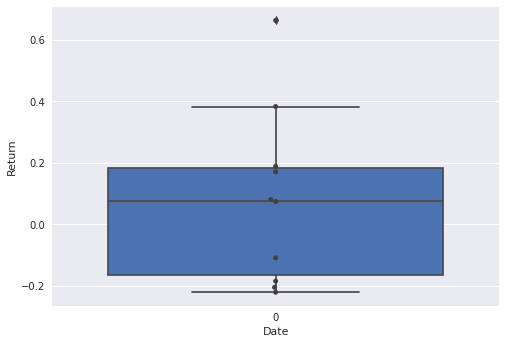

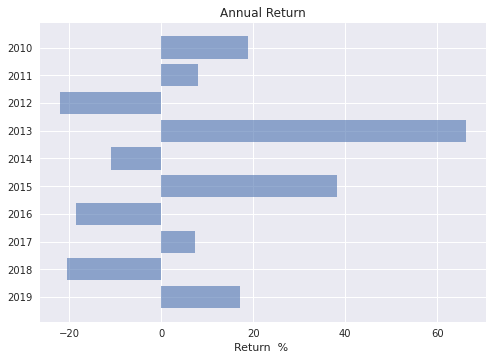

╒═════════════════════════════════════════════╤══════════╕
│ Metrics                                     │    Value │
╞═════════════════════════════════════════════╪══════════╡
│ Compounded Total Return                     │   1.6443 │
├─────────────────────────────────────────────┼──────────┤
│ Compounded Excess Return                    │  -1.0000 │
├─────────────────────────────────────────────┼──────────┤
│ CAGR                                        │   0.1021 │
├─────────────────────────────────────────────┼──────────┤
│ Annualized Volatility                       │   0.2607 │
├─────────────────────────────────────────────┼──────────┤
│ Annualized Negative Volatility              │   0.0247 │
├─────────────────────────────────────────────┼──────────┤
│ Sharpe                                      │   0.3917 │
├─────────────────────────────────────────────┼──────────┤
│ Sortino                                     │   4.1374 │
├─────────────────────────────────────────────┼─────────

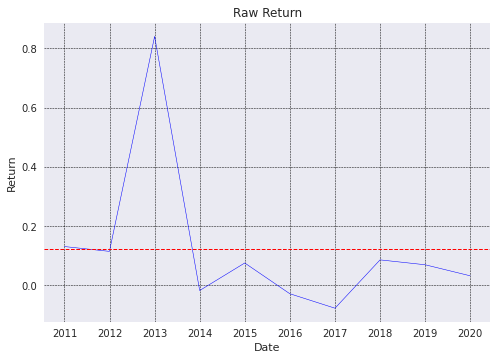

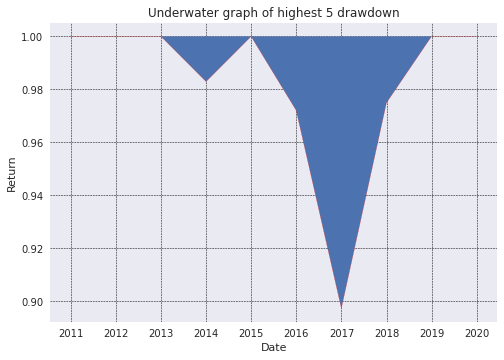

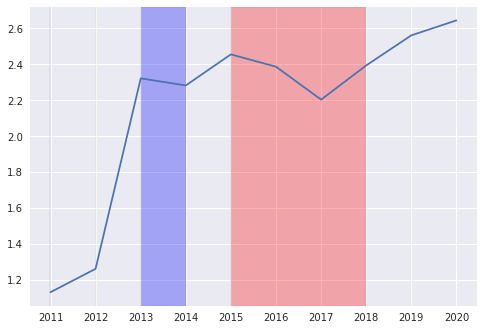

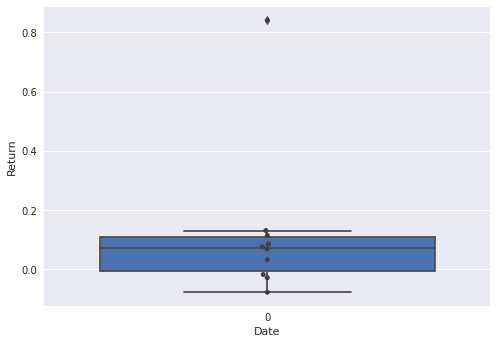

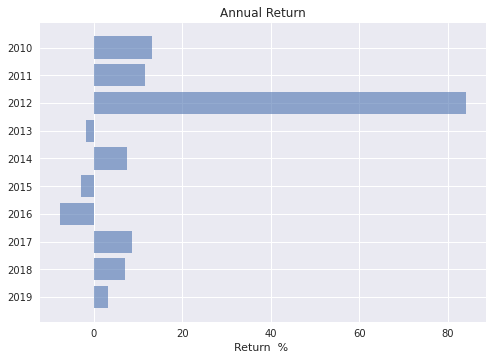

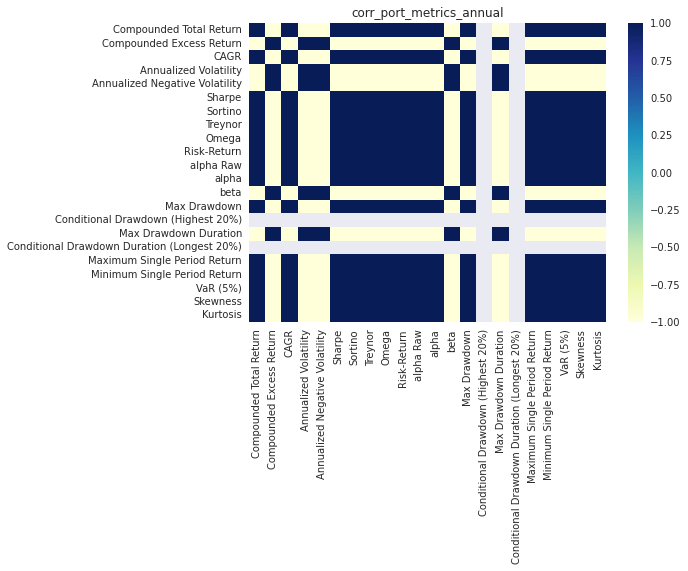

In [8]:
market_annual = (market_daily+1).groupby(pd.Grouper(freq='A')).apply(np.prod) - 1

#data_rf_annual = pd.read_excel('/kaggle/input/data-port/M_TB3MS.xls)
#data_rf_annual = data_rf_annual.iloc[:,1]

#rf_annual = data_rf_annual.iloc[-len_port_annual:] / 12
#rf_annual.index = market_annual.index

rf_annual=True

# constructing portfolios


df_port_rets_annual = (df_port_rets_daily+1).groupby(pd.Grouper(freq='A')).apply(np.prod) - 1

corr_port_annual = df_port_rets_annual.corr().values[np.triu_indices(df_port_rets_annual.shape[1], k=1)]

print(pd.Series(corr_port_annual).describe())
plt.hist(corr_port_annual, bins=1000)

# calculating metrics

port_metrics_annual = df_port_rets_annual.loc[:,:1].apply(lambda x: pd.Series(performance_metrics(x, market=market_annual, rf=rf_annual, freq='Y')), axis=0).T #visualization was made for only one portfolio

corr_port_metrics_annual = port_metrics_annual.corr()
sns.heatmap(corr_port_metrics_annual,cmap="YlGnBu").set_title("corr_port_metrics_annual");